### 1D Burger's equation

$u_t + V uu_{x} - \nu u_{xx}, x\in[-1, 1], t\in[0, 1]$

$u(0, x) = -\sin(\pi x),$

$u(t, -1)=u(t, 1)=0$

In [1]:
import torch
import torch.nn as nn
from torch import autograd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
from copy import deepcopy

### Solve PDE with finite difference using py-pde 

In [2]:
import sys
sys.path.append('./py-pde/')

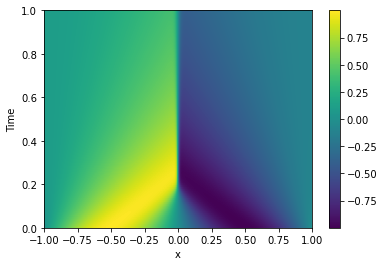

In [14]:
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, ExplicitSolver

class Burger1D(PDEBase):
    def __init__(self, bc, V, nu):
        super(Burger1D, self).__init__()
        self.bc = bc
        self.nu = nu
        self.V = V
    def evolution_rate(self, u, t=0):
        assert u.grid.dim == 1
        u_x = u.gradient("natural")[0]
        return -self.V*u*u_x+self.nu*u.laplace("natural")
    
Nx = 1000
grid = CartesianGrid([[-1, 1]], [Nx], periodic=False)
u = ScalarField.from_expression(grid, "-sin(pi*x)")

storage = MemoryStorage()
eq = Burger1D(bc={"value": 0.0}, V=2, nu=0.01)
eq.solve(u, t_range=1, tracker=storage.tracker(0.01), dt=1e-4)

plot_kymograph(storage)

In [15]:
# reshape the output
xb = grid.axes_bounds[0]
x = np.linspace(*xb, grid.shape[0]+2)
t = np.array(storage.times)
x_mesh, t_mesh = np.meshgrid(x[1:-1], t)
fd_sol = torch.from_numpy(np.concatenate(storage.data)).float().reshape(-1, 1)
sol_t = torch.from_numpy(t_mesh.reshape(-1, 1)).float()
sol_x = torch.from_numpy(x_mesh.reshape(-1, 1)).float()

Nobs = 2000
idx = torch.randint(low=0, high=sol_t.shape[0], size=(Nobs,))
obs_t = sol_t[idx, :]
obs_x = sol_x[idx, :]
obs_u = fd_sol[idx, :]
obs_t.requires_grad, obs_x.requires_grad = True, True

### Define a feedforward network

In [16]:
from collections import OrderedDict

class Dense(nn.Module):
    def __init__(self, activation, inputs, outputs):
        super(Dense, self).__init__()
        self.linear = nn.Linear(inputs, outputs)
        self.activation = activation
    
    def forward(self, x):
        return self.activation(self.linear(x))
    
    
class FFN(nn.Module):
    def __init__(self, activation, n_hidden, n_nodes):
        super(FFN, self).__init__()
        layers = []
        for i in range(n_hidden+2):
            if i == 0:
                layers.append(Dense(activation, 2, n_nodes))
            elif i == n_hidden+1:
                layers.append(nn.Linear(n_nodes, 1))
            else:
                layers.append(Dense(activation, n_nodes, n_nodes))
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x, t):
        xt = torch.cat([x, t], axis=1)
        for l in self.layers:
            xt = l(xt)
        return xt

### Define pde

In [17]:
# defining the PDE residue
def f(net, x, t, V, nu):
    u = net(x, t)
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    return u_t + V*u*u_x - nu*u_xx

In [18]:
# The true initial and boundary value.
def u_init(net, x, t):
    return net(x, t) + torch.sin(np.pi*x)
def u_bc(net, x, t):
    return net(x, t)

### Define loss function, optimizer and train

In [19]:
activation = torch.tanh
n_hidden = 5
n_nodes = 5

In [20]:
net_0 = FFN(activation, n_hidden, n_nodes)
nu = torch.tensor([1.0], requires_grad=True)
V = torch.tensor([0.5], requires_grad=True)
initial_state = deepcopy(net_0.state_dict())
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(net_0.parameters()) + [nu, V])

In [21]:
# Set number of samples
N_init = 50
N_bc = 50
N_f = 5000
max_epochs = 10000

In [22]:
# Create samples from initial condition
x_init = (2.0*torch.rand((N_init, 1), requires_grad=True) - 1.0).to(device)
t_init = (torch.zeros((N_init, 1), requires_grad=True)).to(device)

# Create samples from boundary condition
t_bc = (torch.rand((N_bc, 1), requires_grad=True)).to(device)
x_bc = (torch.ones((N_bc, 1))).to(device)
x_bc[:int(N_bc/2)] = -1
x_bc.requires_grad = True

# Create data point for pde constraint
x_f = (2.0*torch.rand((N_f, 1), requires_grad=True) - 1.0).to(device)
t_f = (torch.rand((N_f, 1), requires_grad=True)).to(device)

errors_0 = []
losses_0 = []
nus_0 = []
Vs_0 = []
for epoch in range(max_epochs):
    nus_0.append(nu.item())
    Vs_0.append(V.item())
    optimizer.zero_grad()
     
    # loss from boundary and initial condition
    mse_u = mse_loss(u_init(net_0, x_init, t_init), torch.zeros_like(t_init)) + \
    mse_loss(u_bc(net_0, x_bc, t_bc), torch.zeros_like(t_bc))
    
    # loss from PDE
    mse_f = mse_loss(f(net_0, x_f, t_f, V, nu), torch.zeros_like(t_f))
    
    # loss from observation
    mse_obs = mse_loss(net_0(obs_x, obs_t), obs_u)
    
    loss = mse_u + mse_f + mse_obs
    
    with autograd.no_grad():
        u = net_0(sol_x, sol_t)
        errors_0.append(mse_loss(u, fd_sol))
        losses_0.append(loss.item())
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Resample data point for pde constraint
    if (epoch+1) % 20 == 0:
        x_f = (2.0*torch.rand((N_f, 1), requires_grad=True) - 1.0).to(device)
        t_f = (torch.rand((N_f, 1), requires_grad=True)).to(device)
    
    if epoch % 500 == 0:
        print('Epoch {}: loss is {}, error is {}, nu is {}, V is {}'.format(epoch, loss, errors_0[-1], nu.item(), V.item()))

Epoch 0: loss is 1.1707963943481445, error is 0.3832370936870575, nu is 0.999005138874054, V is 0.4990038275718689
Epoch 500: loss is 0.42785346508026123, error is 0.12786856293678284, nu is 0.31030604243278503, V is 0.6837770342826843
Epoch 1000: loss is 0.06734679639339447, error is 0.037115346640348434, nu is 0.06567572802305222, V is 0.6127204895019531
Epoch 1500: loss is 0.05329326540231705, error is 0.03679252788424492, nu is 0.07561007887125015, V is 0.6250835061073303
Epoch 2000: loss is 0.040642108768224716, error is 0.030674345791339874, nu is 0.07958871126174927, V is 0.8377454280853271
Epoch 2500: loss is 0.029503263533115387, error is 0.020212560892105103, nu is 0.06132302060723305, V is 1.1516869068145752
Epoch 3000: loss is 0.024264410138130188, error is 0.015836656093597412, nu is 0.05517333000898361, V is 1.3062947988510132
Epoch 3500: loss is 0.02131658047437668, error is 0.013305232860147953, nu is 0.050008028745651245, V is 1.3837780952453613
Epoch 4000: loss is 0.0

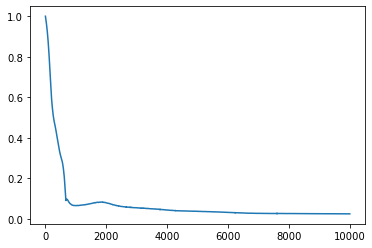

In [25]:
import matplotlib.pyplot as plt
plt.plot(nus_0)

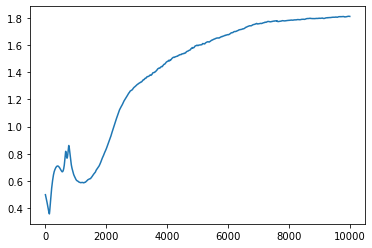

In [26]:
plt.plot(Vs_0)